In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform
from cimcb.model import PLS_SIMPLS as PLSDA
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.metrics import r2_score
import NN_LogitLogit as ANN
from statsmodels.stats.multitest import multipletests

Using TensorFlow backend.


c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (235). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


119
59 13
9
training error:  0.18055555555555555
[[50  9]
 [ 4  9]]
[[0.09172006]] [-0.02754381]
14_2-hydroxyquinoline 0.48725583682690554 0.2194446238588907
37_Arachidic acid 0.46773445487090315 -0.530148928852675
54_D Glucopyranuronic acid 1.2754169853969177 0.5682157295715989
55_D Hydroxyglutaric acid 1.1123920471106568 1.3171174680562792
77_Kynurenic acid 0.8456536734308813 0.10395165039782862
80_L   Malic acid 0.841343666312272 1.0001346354582703
116_raspberry ketone 1.1413462282242945 -0.8453157389537916
135_1 Methyladenosine 0.7307845047281863 0.7786000241681691
196_Kynurenic acid 1.5556333664546955 0.242037750891295


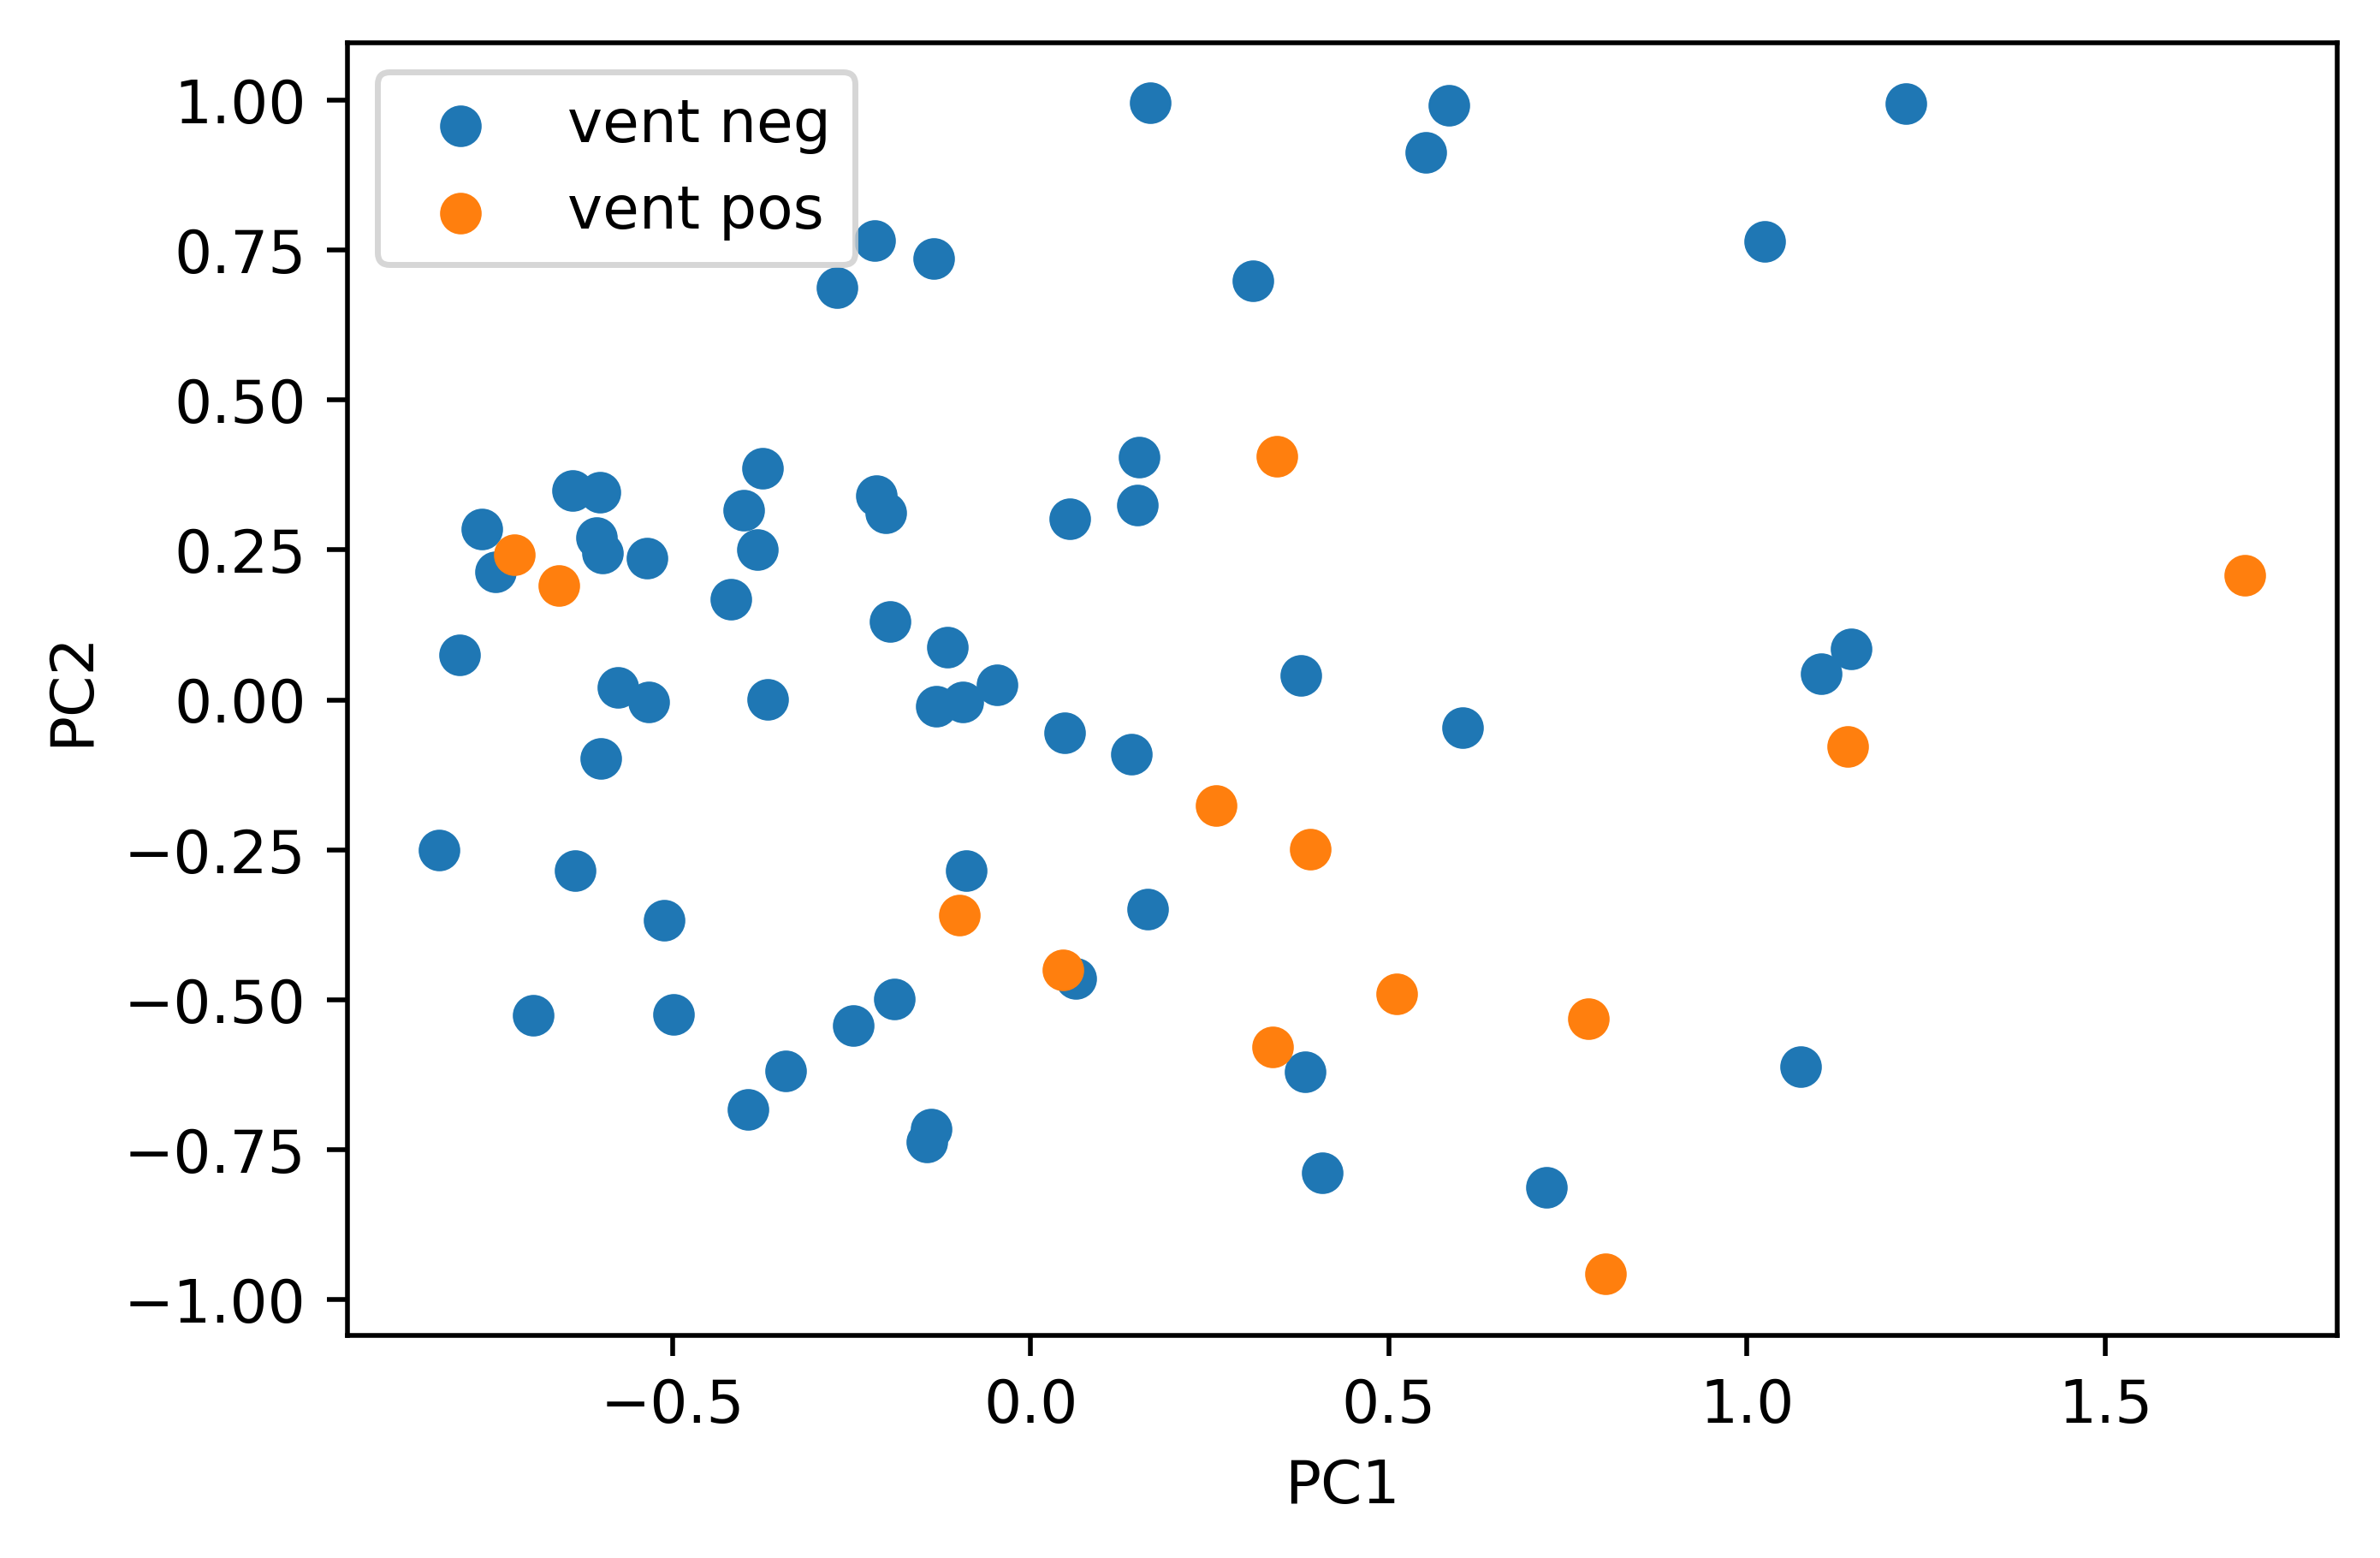

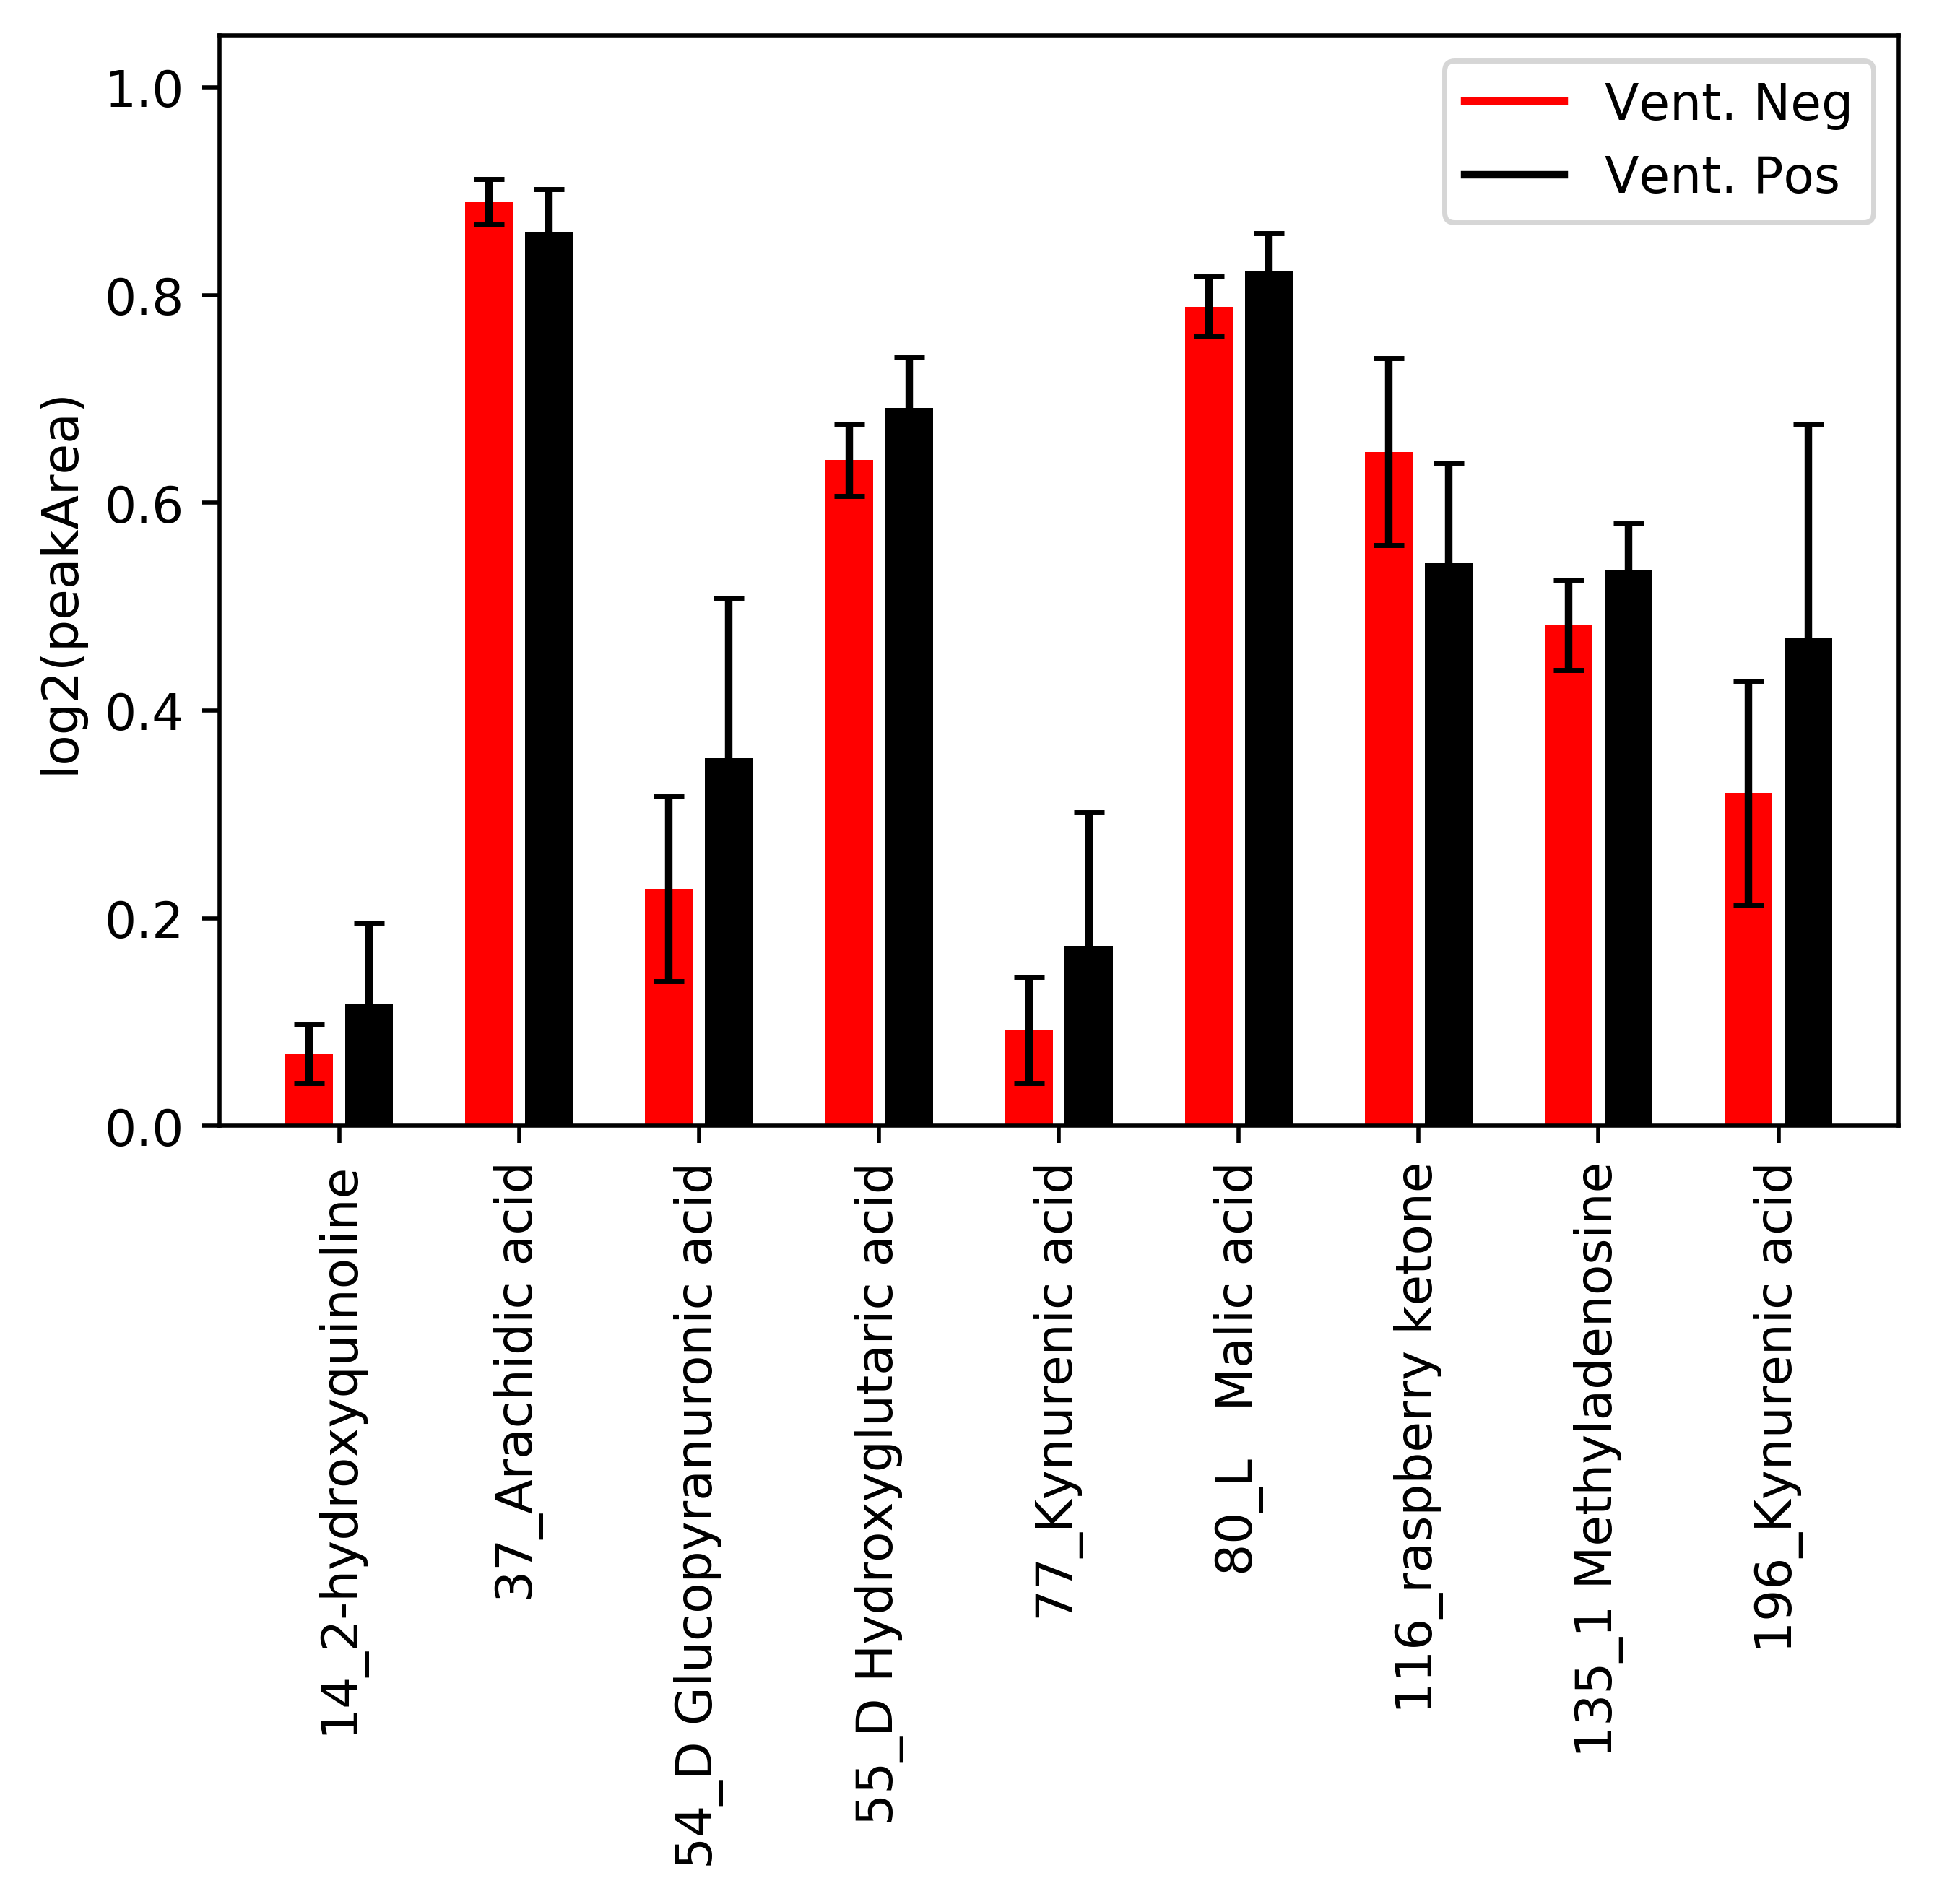

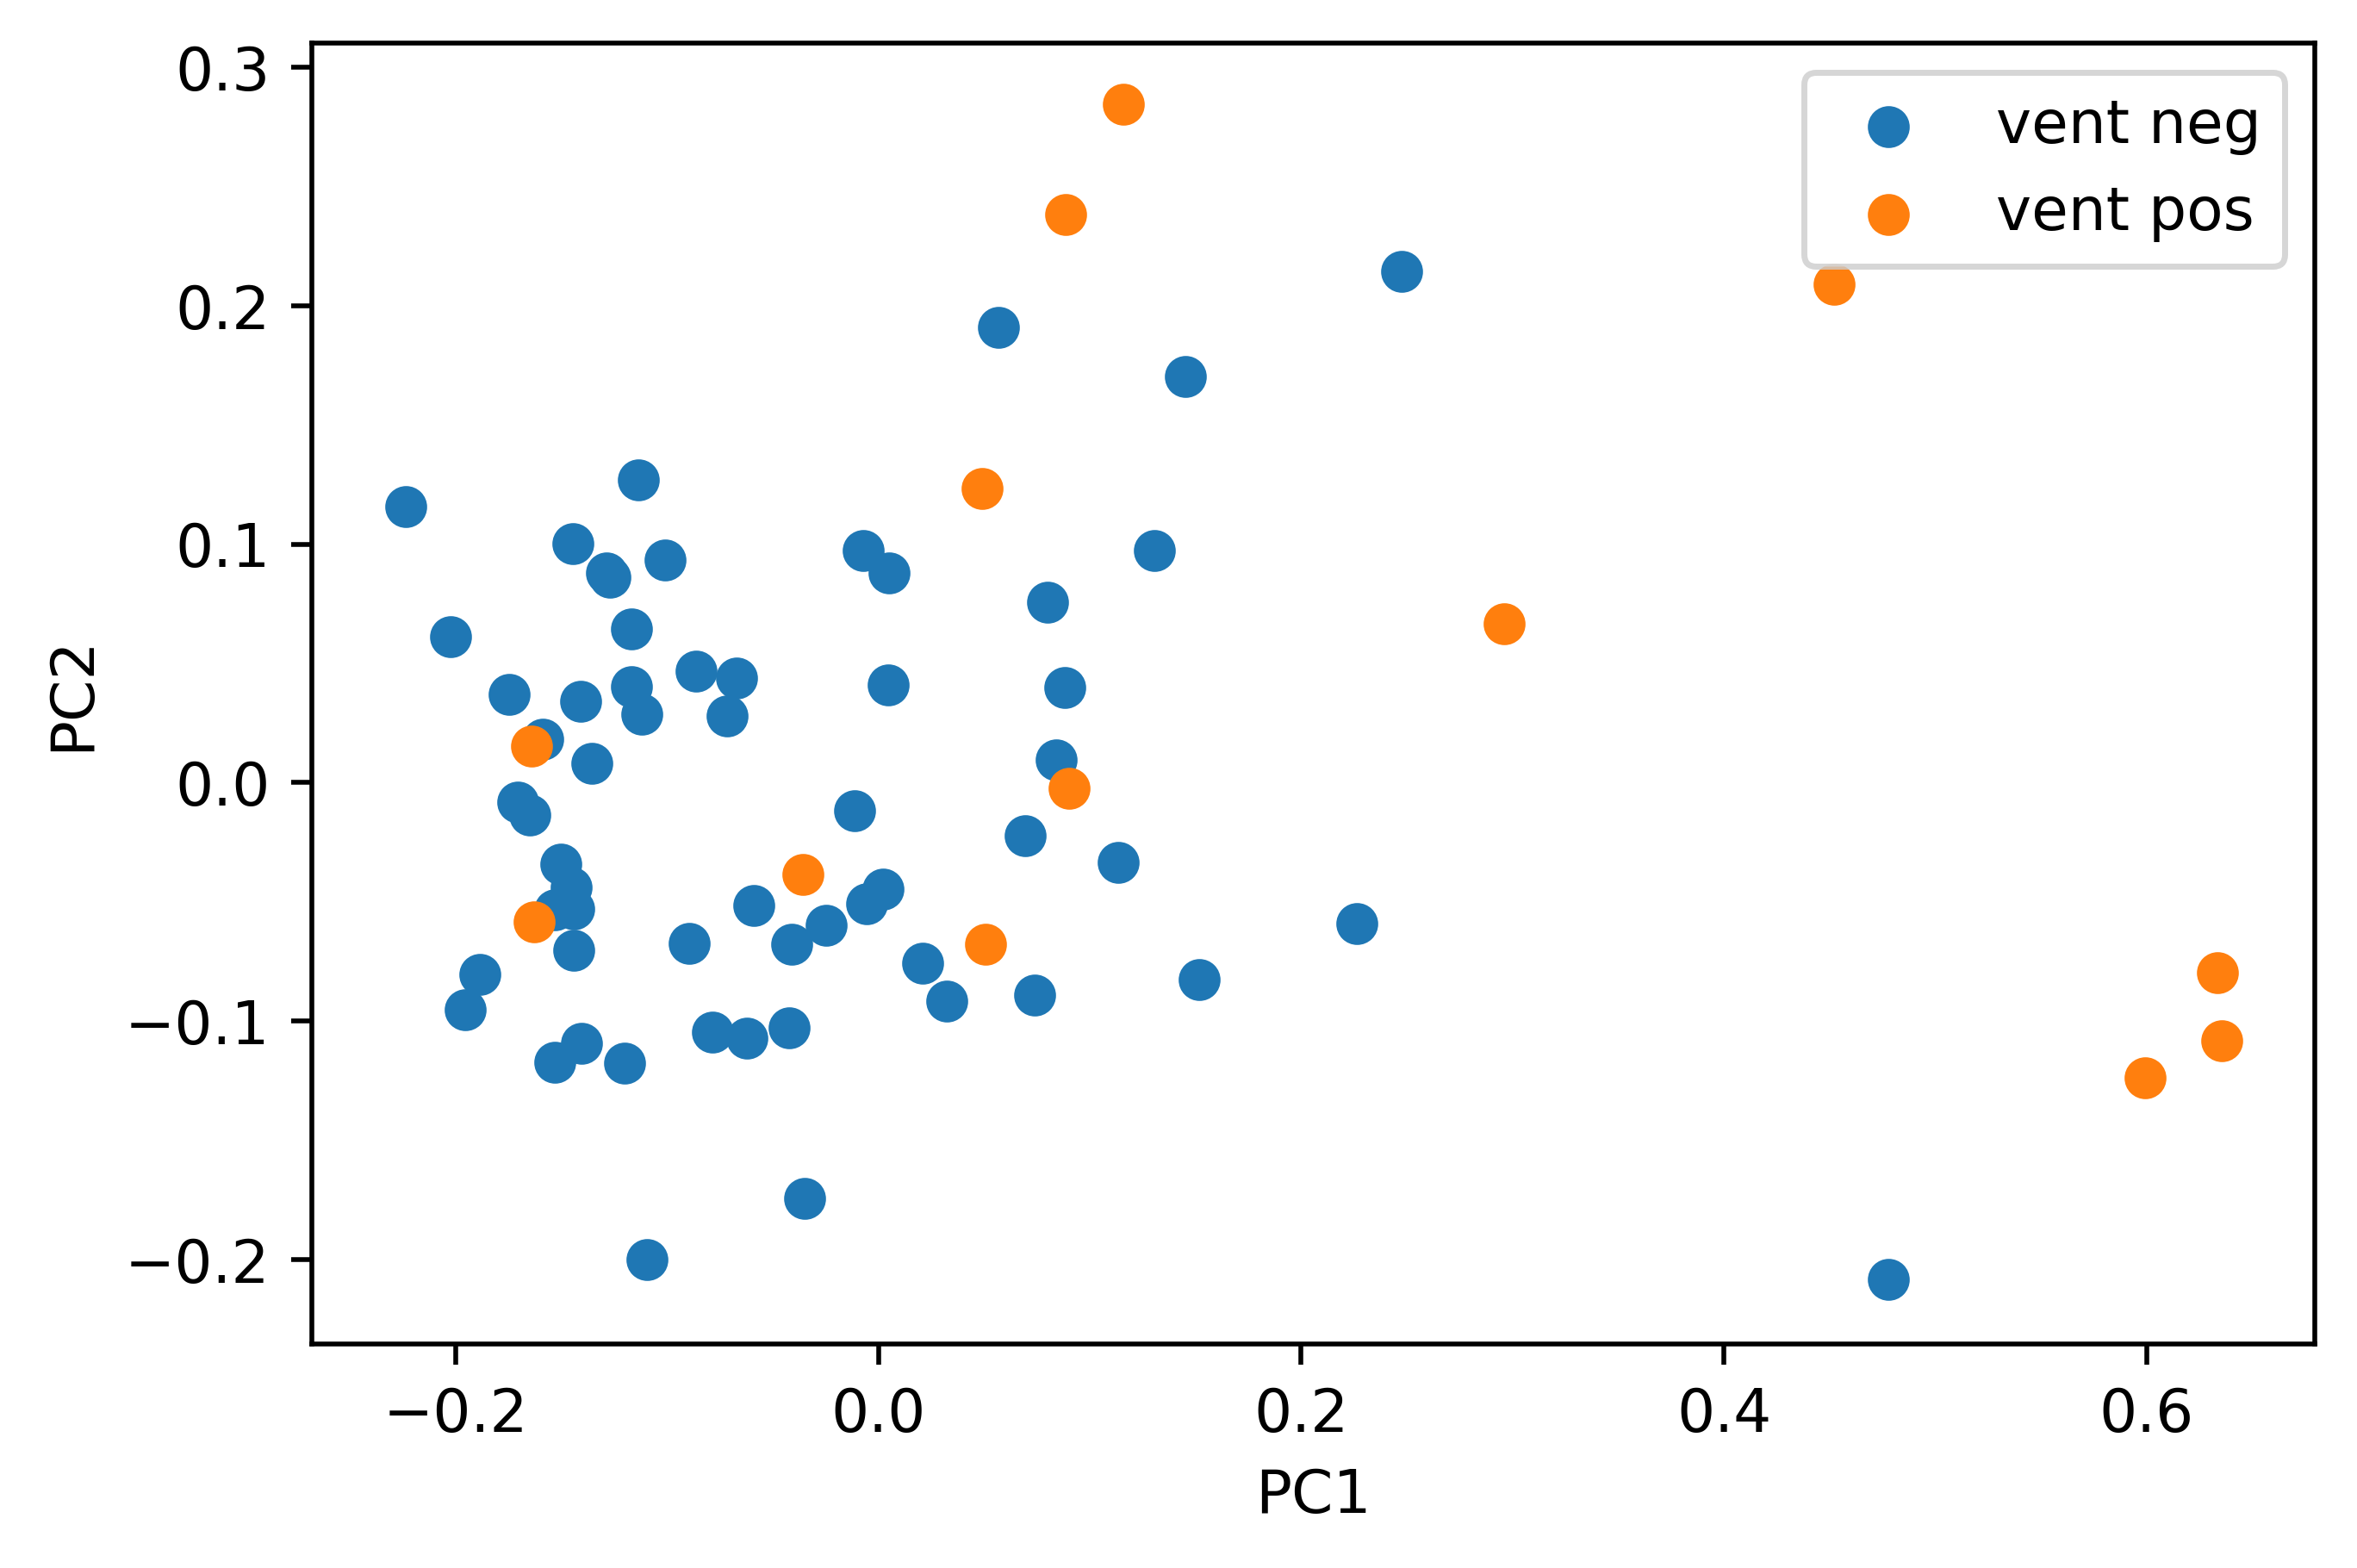

<Figure size 3000x2000 with 0 Axes>

In [71]:
#load trainining data and train model
datafilename = "06_16_2020_identified_features_peak_areas_imputted.csv"
data = pd.read_csv(datafilename)

areaCols = [x for x in data.columns.values if "Area" in x]
areaData = data[areaCols].transpose()

data_imp  = np.log2(areaData.to_numpy())
data_imp_norm = quantile_transform(data_imp,1)

sampCols = [x for x in range(len(areaCols)) if "WU350" in areaCols[x] and not "equil" in areaCols[x]]
sampData = data_imp_norm[sampCols]

blankSamp = [x for x in range(len(areaCols)) if "Blank" in areaCols[x] and not "equil" in areaCols[x]]
blankData = data_imp_norm[blankSamp]

metadata = pd.read_csv("experiment_parameters.csv")
samp2rowMap = {r.split()[0].replace("pns_","p"):i for r,i in zip(areaCols,range(len(areaCols)))}
row2Samp = {val:key for key,val in samp2rowMap.items()}

numMets = len(blankData[0])
pvalCutoff = 0.05
pvals = []
for met in range(numMets):
    b = blankData[:,met]
    s = sampData[:,met]
    t,p = stats.ttest_ind(b,s,equal_var=False)
    pvals.append(p)
        
reject,pvals_corr,_,_ = multipletests(pvals,pvalCutoff,method="fdr_bh")
goodMets = [x for x in range(len(reject)) if reject[x]]
        
sampData_sig = sampData[:,goodMets]
vent_status_neg = [sampCols.index(samp2rowMap[row["Sample"]]) for index,row in metadata.iterrows() if row["Sample"] in samp2rowMap and "No" in str(row["Epic: Subject on ventilation at any point after biospecimen sample 1"]) and "d0_Yes" in str(row["day-COVID"])]
vent_status_pos = [sampCols.index(samp2rowMap[row["Sample"]]) for index,row in metadata.iterrows() if row["Sample"] in samp2rowMap and "Yes" in str(row["Epic: Subject on ventilation at any point after biospecimen sample 1"]) and "d0_Yes" in str(row["day-COVID"])]

print(len(metadata[metadata["day-COVID"] == "d0_Yes"]))

print(len(vent_status_neg),len(vent_status_pos))

vent_status = [1 for x in range(len(sampData_sig))]
for ind in vent_status_neg:
    vent_status[ind] = 0

ind = vent_status_neg + vent_status_pos
X_whole = sampData_sig[ind,:]
y_whole = [vent_status[x] for x in ind]

pca = PCA(n_components=2)

data_reduced = pca.fit_transform(X_whole)

plt.scatter(data_reduced[:len(vent_status_neg),0],data_reduced[:len(vent_status_neg),1],label="vent neg")
plt.scatter(data_reduced[len(vent_status_neg):,0],data_reduced[len(vent_status_neg):,1],label="vent pos")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.figure()

        
#repeat on entire dataset
ventNeg = np.array([x for x,y in zip(X_whole,y_whole) if y < .5])
ventPos = np.array([x for x,y in zip(X_whole,y_whole) if y > .5])

pval = 0.05
fc = 2.0

pvals = []
for met in range(len(ventNeg[0])):
    stat,p = stats.ttest_ind(ventNeg[:,met],ventPos[:,met])
    pvals.append(p)
        
reject,pvals_corr,_,_ = multipletests(pvals,pval,method="fdr_bh")
sigMet = [x for x in range(len(reject)) if reject[x]]
        
print(len(sigMet))
    
xpos = 0
poses = []
labels = []
for met in sigMet:
    metName = data.at[data.index.values[goodMets[met]],"Molecule Name"]#.split("_")[1]
    plt.bar([xpos,xpos+1],[np.mean(ventNeg[:,met]),np.mean(ventPos[:,met])],yerr=[np.std(ventNeg[:,met]),np.std(ventPos[:,met])],color=["red","black"],capsize=3)
    poses.append(xpos+.5)
    labels.append(metName)
    xpos += 3
    
plt.plot([-10,-10],[0,1],color="red",label="Vent. Neg")
plt.plot([-10,-10],[0,1],color="black",label="Vent. Pos")

plt.xticks(poses,labels=labels,rotation = 90)
plt.xlim((min(poses)-2,max(poses)+2))
plt.legend()
plt.ylabel("log2(peakArea)")

plt.figure()

data_reduced = pca.fit_transform(X_whole[:,sigMet])

plt.scatter(data_reduced[:len(vent_status_neg),0],data_reduced[:len(vent_status_neg),1],label="vent neg")
plt.scatter(data_reduced[len(vent_status_neg):,0],data_reduced[len(vent_status_neg):,1],label="vent pos")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

numPos = len([x for x in y_whole if x > .5])
numNeg = len(y_whole) - numPos
sampleWeights = [.50/numPos for _ in y_whole]
for x in range(len(y_whole)):
    if y_whole[x] < .5:
        sampleWeights[x] = .50/numNeg


plt.figure()

nc = 2
    
pls = PLSDA(n_components=nc)

pls.train(X_whole[:,sigMet],y_whole)

y_train_pred = pls.test(X_whole[:,sigMet])

logClass = LogisticRegression(fit_intercept=True,max_iter=1e4)

logClass.fit([[x] for x in y_train_pred],y_whole,sample_weight = sampleWeights)

y_train_pred_corr = logClass.predict([[x] for x in y_train_pred])

err_train = np.sum(np.abs(np.subtract(y_whole,y_train_pred_corr)))/len(y_whole)

print("training error: ",err_train)

print(sklearn.metrics.confusion_matrix(y_whole,y_train_pred_corr))

print(logClass.coef_,logClass.intercept_)
cont_dict = {}
for name,val,coef in zip(labels,pls.model.vip_,pls.model.coef_):
    print(name,val,coef)
    cont_dict[name] = {"VIP":val,"Coefficient":coef}
    


In [72]:
#load validation data

datafilename = "batch56_validation_06_25_2020_identified_features_peak_areas_imputted.csv"
data = pd.read_csv(datafilename)

areaCols = [x for x in data.columns.values if "Area" in x]
areaData = data[areaCols].transpose()

data_imp  = np.log2(areaData.to_numpy())
data_imp_norm = quantile_transform(data_imp,1)

sampCols = [x for x in range(len(areaCols)) if "WU350" in areaCols[x] and not "equil" in areaCols[x]]
sampData = data_imp_norm[sampCols]


metadata = pd.read_csv("06252020_experiment_parameters.csv")
samp2rowMap = {r.split()[0].replace("pns_",""):i for r,i in zip(areaCols,range(len(areaCols)))}
row2Samp = {val:key for key,val in samp2rowMap.items()}


vent_status_neg = [sampCols.index(samp2rowMap[row["Sample2"]]) for index,row in metadata.iterrows() if row["Sample2"] in samp2rowMap and "No" in str(row["Epic: Subject on ventilation at any point after biospecimen sample 1"]) and "d0_Yes" in str(row["day-COVID"])]
vent_status_pos = [sampCols.index(samp2rowMap[row["Sample2"]]) for index,row in metadata.iterrows() if row["Sample2"] in samp2rowMap and "Yes" in str(row["Epic: Subject on ventilation at any point after biospecimen sample 1"]) and "d0_Yes" in str(row["day-COVID"])]

ind = vent_status_neg + vent_status_pos

vent_status = [1 for x in range(len(sampData))]
for i in vent_status_neg:
    vent_status[i] = 0


new_met_ind = []

for l in labels:
    for m,i in zip(data["Molecule Name"].values,range(len(data["Molecule Name"]))):
        if m == l:
            new_met_ind.append(i)
            break
X_val = sampData[ind,:]
X_val = X_val[:,new_met_ind]
y_val = np.array(vent_status)[ind]

y_pred = logClass.predict([[x] for x in pls.test(X_val)])

err_test = np.sum(np.abs(np.subtract(y_val,y_pred)))/len(y_pred)

print("testing error: ",err_test)

print(sklearn.metrics.confusion_matrix(y_val,y_pred))

testing error:  0.22857142857142856
[[22  6]
 [ 2  5]]


c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (234). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
